In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def constant32(k):
    return tf.constant(k,dtype = tf.float32)

In [3]:
x_1 = constant32([[0., 1.]])

x_1_tiled = tf.tile(x_1,[2,1])

In [4]:
@tf.function
def squared_euclidean_distance(x_1,x_2):
    sqd = tf.sqrt(tf.reshape(tf.reduce_sum(x_1**2,1),shape =(x_1.shape[0],1))+\
    tf.reshape(tf.reduce_sum(x_2**2,1),shape =(1,x_2.shape[0]))-\
    2*tf.tensordot(x_1,tf.transpose(x_2),1))
    return sqd

In [5]:
#Cartesian distances
def cartesian_dist(x_1,x_2):
    return tf.concat([
        tf.tile(x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        tf.tile(x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 
h_u = cartesian_dist(x_1,x_1)

In [6]:
dist_tiled = squared_euclidean_distance(x_1_tiled,x_1_tiled)

In [7]:
h_u

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [8]:
h_v = tf.transpose(h_u)

In [9]:
a = tf.concat([tf.ones([x_1.shape[0],x_1.shape[0]]),tf.zeros([x_1.shape[0],x_1.shape[0]])],axis = 1)
b = tf.concat([tf.zeros([x_1.shape[0],x_1.shape[0]]),tf.ones([x_1.shape[0],x_1.shape[0]])],axis = 1)

perpendicularity_matrix = tf.concat([a,b],axis = 0)

In [10]:
a_T = 5
c_o_T = a_T**2/14/3

In [11]:
index = tf.where(dist_tiled==0).numpy()

In [12]:
def cov_gradients(dist_tiled):
    C_G = (tf.math.divide_no_nan(h_u*h_v , dist_tiled**2)*\
    (-c_o_T*((-14/a_T**2)+105/4*dist_tiled/a_T**3 - 35/2 * dist_tiled**3 / a_T **5 + 21 /4 * dist_tiled**5/a_T**7)+
        c_o_T * 7 * (9 * dist_tiled ** 5 - 20 * a_T ** 2 * dist_tiled ** 3 +
                                       15 * a_T ** 4 * dist_tiled - 4 * a_T ** 5) / (2 * a_T ** 7)-
        perpendicularity_matrix * c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                                   21 / 4 * dist_tiled ** 5 / a_T ** 7))+
        1/3*tf.eye(dist_tiled.shape[0])) ## adding nugget effect
    return C_G

In [13]:
dist_tiled = dist_tiled + tf.eye(dist_tiled.shape[0])

In [14]:
C_G = cov_gradients(dist_tiled)

In [15]:
C_G

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.33333334, 0.        ],
       [0.        , 0.33333334]], dtype=float32)>

### covariance of interface points

In [18]:
## first layer we have 2 points
layer1 = constant32([[0,0],[2,0],[3,0.3]])
layer2 = constant32([[0,2],[2,2],[3,3.3]])

In [19]:
ref_layer_points = tf.stack([layer1[-1],layer2[-1]],axis = 0)
rest_layer_points = tf.concat([layer1[0:-1],layer2[0:-1]],axis = 0)

In [20]:
sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

In [21]:
def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*((1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7) +\
                 (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7))
    
    return C_I

In [22]:
C_I = cov_interface(ref_layer_points,rest_layer_points)

InvalidArgumentError: Incompatible shapes: [4,4] vs. [2,4] [Op:Sub] name: sub/

In [23]:
C_I

NameError: name 'C_I' is not defined

### Covariance of interface points and gradients

In [230]:
rest_layer_points

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 2.]], dtype=float32)>

In [231]:
sed_dips_rest = squared_euclidean_distance(x_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(x_1_tiled,ref_layer_points)

In [232]:
x_1_tiled

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.]], dtype=float32)>

In [277]:
rest_layer_points

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 2.]], dtype=float32)>

In [234]:
## Cartesian distance between dips and interface points
#Cartesian distances
def cartesian_dist_no_tile(x_1,x_2):
    return tf.concat([
        tf.transpose((x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]))),
        tf.transpose((x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

hu_rest = cartesian_dist_no_tile(x_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(x_1,ref_layer_points)

In [284]:
def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = (hu_rest*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7))-\
    hu_ref*(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)))
    return C_GI

In [285]:
C_GI = cov_interface_gradients(hu_rest,hu_ref)

In [307]:
C_IG = tf.transpose(C_GI)

In [308]:
C_GI

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.17771314,  0.17771314],
       [ 0.12277011, -0.12277011]], dtype=float32)>

### Kriging Matrix

In [309]:
K = tf.concat([tf.concat([C_G,C_GI],axis = 1),
tf.concat([C_IG,C_I],axis = 1)],axis = 0)

In [310]:
b = tf.reshape(constant32([1,1,0,0]),[4,1])

In [311]:
K

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.33333334,  0.        ,  0.17771314,  0.17771314],
       [ 0.        ,  0.33333334,  0.12277011, -0.12277011],
       [ 0.17771314,  0.12277011,  0.7078706 ,  0.29798672],
       [ 0.17771314, -0.12277011,  0.29798672,  0.7078706 ]],
      dtype=float32)>

In [312]:
w = tf.linalg.solve(K,b)

In [313]:
w

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ 3.6963491],
       [ 3.8492908],
       [-1.8060198],
       [ 0.4998908]], dtype=float32)>

In [314]:
np.linalg.solve(K.numpy(),b.numpy())

array([[ 3.696349 ],
       [ 3.8492906],
       [-1.8060199],
       [ 0.4998908]], dtype=float32)

### Now need to find a way to interpolate

In [315]:
xx = tf.range(-.5,2.5,0.1)
yy = tf.range(-.5,2.5,0.1)
XX,YY = tf.meshgrid(xx,yy)
X = tf.transpose(tf.reshape(XX,[-1]))
Y = tf.transpose(tf.reshape(YY,[-1]))

In [316]:
grid = tf.stack([X,Y],axis = 1)

In [317]:
hu_Simpoints = cartesian_dist_no_tile(x_1,grid)

In [318]:
sed_dips_SimPoint = squared_euclidean_distance(x_1_tiled,grid)

In [319]:
sigma_0_grad = w[:2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

In [320]:
sigma_0_grad = tf.reduce_sum(sigma_0_grad,axis=0)

In [321]:
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)

In [322]:
sigma_0_interf = -w[2:4]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -\
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = tf.reduce_sum(sigma_0_interf,axis = 0)

In [323]:
interpolate_result = sigma_0_grad+sigma_0_interf

In [324]:
interpolate_result.shape

TensorShape([900])

In [325]:
intp = tf.reshape(interpolate_result,[30,30])

In [327]:
x1 = [0,0]
x2 = [2,0]
x_int1 = np.vstack([x1,x2])
# interface 2:
x3 = [0,2]
x4 = [2,2]
x_int2 = np.vstack([x3,x4])
# orientation point:
x5 = [0,1]
x = np.vstack([x1, x2, x3, x4, x5])
# orientation values
gx5 = 1.
gy5 = 1.

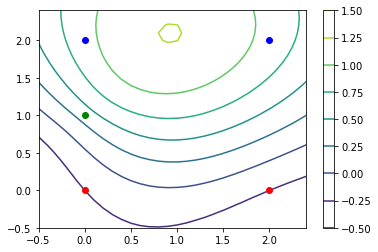

In [328]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(x_int1[:,0], x_int1[:,1], 'ro')
plt.plot(x_int2[:,0], x_int2[:,1], 'bo')
plt.plot(x5[0], x5[1], 'go')

### debug
